In [1]:
import torch
from transformers import BartTokenizer, BartForConditionalGeneration
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from rouge_score import rouge_scorer
from torch.cuda.amp import GradScaler, autocast

In [2]:
from tqdm import tqdm

In [3]:
def check_gpu():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    return device

device = check_gpu()

Using device: cuda


In [4]:

# Step 1: Load and Prepare Data
def load_and_clean_data(dataset_name, subset=None, sample_size=10000):
    print(f"Loading {dataset_name} dataset...")
    dataset = load_dataset(dataset_name, subset) if subset else load_dataset(dataset_name)

    # Take a random sample
    if 'train' in dataset:
        dataset['train'] = dataset['train'].shuffle(seed=42).select(range(min(sample_size, len(dataset['train']))))

    # Cleaning (Example: Remove long documents and normalize text)
    def clean_text(example):
        if 'document' in example and 'summary' in example:
            example['document'] = example['document'].replace("\n", " ").strip()
            example['summary'] = example['summary'].replace("\n", " ").strip()
        elif 'article' in example and 'highlights' in example:
            example['article'] = example['article'].replace("\n", " ").strip()
            example['highlights'] = example['highlights'].replace("\n", " ").strip()
        return example

    dataset = dataset.map(clean_text)
    return dataset

In [5]:
xsum_data = load_and_clean_data("EdinburghNLP/xsum")
cnn_data = load_and_clean_data("cnn_dailymail", "3.0.0")

Loading EdinburghNLP/xsum dataset...
Loading cnn_dailymail dataset...


In [6]:
# Function to calculate statistics
import numpy as np
def calculate_statistics(dataset, text_column):
    lengths = [len(example[text_column].split()) for example in dataset]
    min_length = np.min(lengths)
    max_length = np.max(lengths)
    std_dev = np.std(lengths)
    avg_length = np.mean(lengths)
    return min_length, max_length, std_dev, avg_length

# For XSum dataset
xsum_train = xsum_data["train"]
xsum_min, xsum_max, xsum_avg, xsum_std = calculate_statistics(xsum_train, "document")
xsum_sum_min, xsum_sum_max, xsum_sum_avg, xsum_sum_std = calculate_statistics(xsum_train, "summary")
print(f"XSum Dataset - Min: {xsum_min}, Max: {xsum_max},Avg: {xsum_avg}, Std Dev: {xsum_std}")
print(f"XSum Dataset - Min: {xsum_sum_min}, Max: {xsum_sum_max},Avg: {xsum_sum_avg}, Std Dev: {xsum_sum_std}")

# For CNN/DM dataset
cnn_train = cnn_data["train"]
cnn_min, cnn_max, cnn_avg, cnn_std = calculate_statistics(cnn_train, "article")
cnn_sum_min, cnn_sum_max, cnn_sum_avg, cnn_sum_std = calculate_statistics(cnn_train, "highlights")
print(f"CNN Dataset - Min: {cnn_min}, Max: {cnn_max},Avg: {cnn_avg}, Std Dev: {cnn_std}")
print(f"CNN Dataset - Min: {cnn_sum_min}, Max: {cnn_sum_max},Avg: {cnn_sum_avg}, Std Dev: {cnn_sum_std}")


XSum Dataset - Min: 0, Max: 6789,Avg: 290.00679922374235, Std Dev: 370.198
XSum Dataset - Min: 1, Max: 52,Avg: 5.199118844573569, Std Dev: 21.1018
CNN Dataset - Min: 37, Max: 1967,Avg: 336.0333807904209, Std Dev: 691.9384
CNN Dataset - Min: 6, Max: 421,Avg: 20.40974947812932, Std Dev: 51.1932


In [7]:
# Load datasets
xsum_dataset = load_dataset("EdinburghNLP/xsum")['train']  # Load the training split
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0")['train']  # Load the training split
cnn_dataset_validation = load_dataset("cnn_dailymail", "3.0.0")['validation']  # Load the training split


In [8]:
# Step 2: Split Data
def split_dataset(dataset, text_column, summary_column):
    data = [{"text": example[text_column], "summary": example[summary_column]} for example in dataset]
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    return train_data, val_data

In [9]:
xsum_train, xsum_val = split_dataset(xsum_data['train'], 'document', 'summary')
cnn_train, cnn_val = split_dataset(cnn_data['train'], 'article', 'highlights')


Training samples: 8000, Validation samples: 2000
Training samples: 8000, Validation samples: 2000


In [10]:
# Combine datasets for training and validation
train_data = xsum_train + cnn_train
val_data = xsum_val + cnn_val

In [11]:
import matplotlib.pyplot as plt

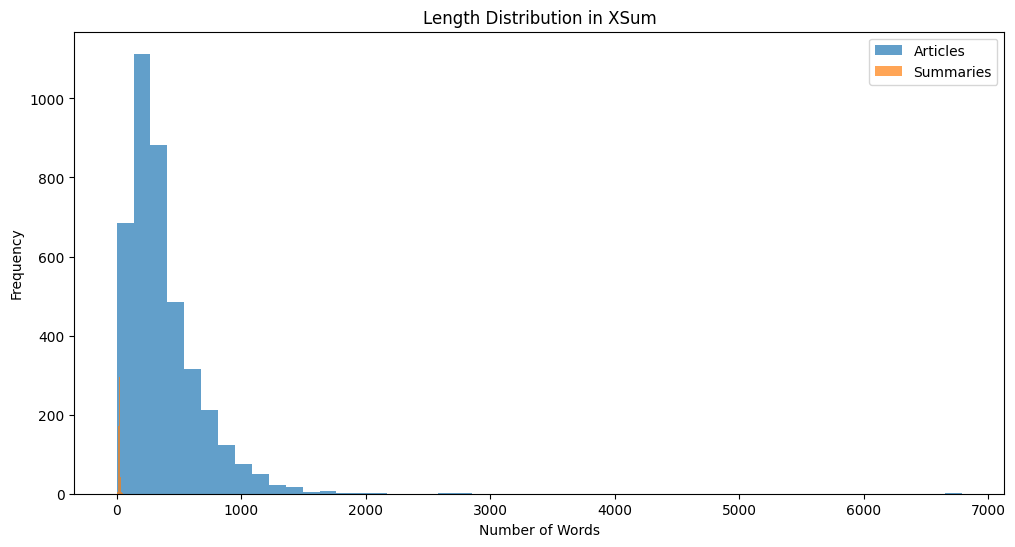

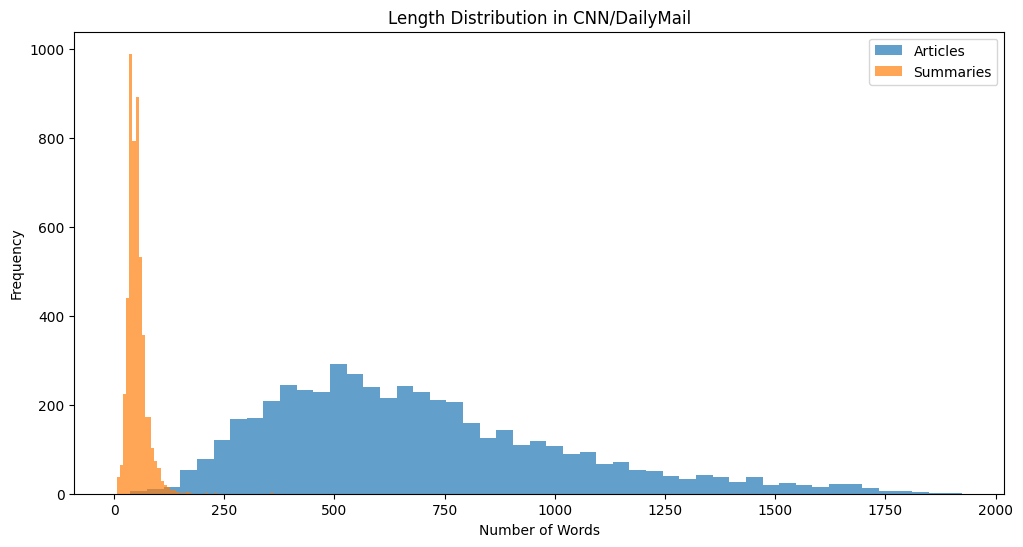

In [48]:
# Step 3: Exploratory Data Analysis
def plot_length_distributions(data, text_column, summary_column, dataset_name):
    article_lengths = [len(d[text_column].split()) for d in data]
    summary_lengths = [len(d[summary_column].split()) for d in data]

    plt.figure(figsize=(12, 6))
    plt.hist(article_lengths, bins=50, alpha=0.7, label="Articles")
    plt.hist(summary_lengths, bins=50, alpha=0.7, label="Summaries")
    plt.title(f"Length Distribution in {dataset_name}")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_length_distributions(xsum_train, "text", "summary", "XSum")
plot_length_distributions(cnn_data['train'], 'article', 'highlights', "CNN/DailyMail")

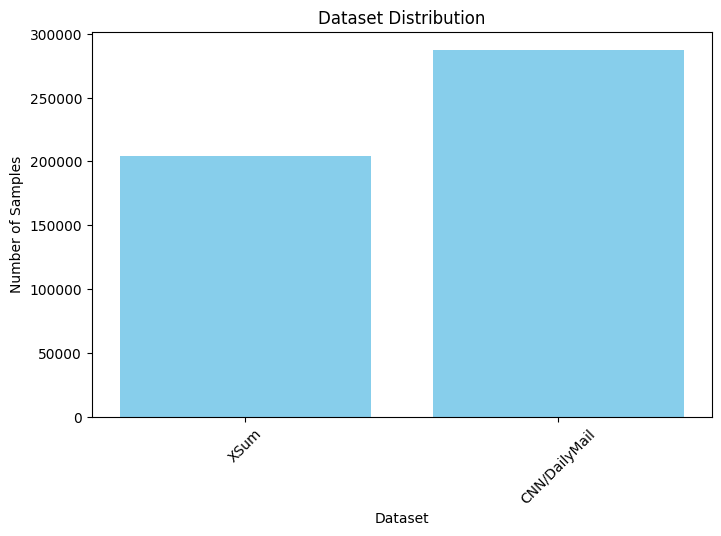

In [12]:
# Function to plot dataset distribution
def plot_dataset_distribution(data_sizes, dataset_names):
    plt.figure(figsize=(8, 5))
    plt.bar(dataset_names, data_sizes, color="skyblue")
    plt.title("Dataset Distribution")
    plt.xlabel("Dataset")
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

# Get accurate counts
data_sizes = [len(xsum_dataset), len(cnn_dataset)]
dataset_names = ["XSum", "CNN/DailyMail"]

# Plot the distribution
plot_dataset_distribution(data_sizes, dataset_names)

In [18]:
# Step 3: Tokenization
def tokenize_data(data, tokenizer):
    def preprocess(example):
        inputs = tokenizer(example['text'], max_length=1024, truncation=True, return_tensors="pt")
        labels = tokenizer(example['summary'], max_length=128, truncation=True, return_tensors="pt")
        return {"input_ids": inputs['input_ids'], "attention_mask": inputs['attention_mask'], "labels": labels['input_ids']}

    tokenized_data = [preprocess(example) for example in data]
    return tokenized_data

In [19]:
print("Loading tokenizer...")
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)

train_tokenized = tokenize_data(train_data, tokenizer)
val_tokenized = tokenize_data(val_data, tokenizer)

Loading tokenizer...


In [188]:
import time

In [189]:
from torch.utils.data import DataLoader

In [199]:
# Step 4: Train Model
def train_model(train_tokenized, val_tokenized):
    model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    scaler = GradScaler()  # Mixed precision training
    num_epochs = 20
    train_losses = []
    val_losses = []
     # Define accumulation steps
    accumulation_steps = 4
    batch_size = 16
    train_loader = DataLoader(train_tokenized,batch_size=batch_size ,shuffle=True, num_workers=4)

    for epoch in range(num_epochs):
        start_time = time.time()  # Start time for the epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        epoch_loss = 0.0
        # Create a progress bar for the training batches
        progress_bar = tqdm(train_tokenized, desc=f"Training Epoch {epoch + 1}", unit="batch")
        for i, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            epoch_loss += loss.item()
            scaler.scale(loss).backward()
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        print(f"Epoch {epoch+1} Loss: {loss.item()}")
        progress_bar.set_postfix(loss=loss.item())


        avg_train_loss = epoch_loss / len(train_tokenized)
        train_losses.append(avg_train_loss)
        print(f"Loss after epoch {epoch+1}: {avg_train_loss}")
        # Calculate elapsed time and estimated time remaining
        elapsed_time = time.time() - start_time
        avg_epoch_time = elapsed_time / (epoch + 1)  # Average time per epoch
        remaining_epochs = num_epochs - (epoch + 1)
        estimated_time_remaining = remaining_epochs * avg_epoch_time

        print(f"Elapsed time for epoch {epoch + 1}: {elapsed_time:.2f} seconds")
        print(f"Estimated time remaining: {estimated_time_remaining:.2f} seconds")


    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.show()

    return model


C:\Users\prana\AppData\Local\Temp\ipykernel_21992\2591978296.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision training


Epoch 1/20


Training Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [11:56<00:00, 11.17batch/s]


Epoch 1 Loss: 2.2235934734344482
Loss after epoch 1: 2.4441120952181516
Elapsed time for epoch 1: 716.40 seconds
Estimated time remaining: 13611.54 seconds
Epoch 2/20


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [10:35<00:00, 12.59batch/s]


Epoch 2 Loss: 2.1373744010925293
Loss after epoch 2: 2.2214866455085573
Elapsed time for epoch 2: 635.32 seconds
Estimated time remaining: 5717.85 seconds
Epoch 3/20


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [11:35<00:00, 11.50batch/s]


Epoch 3 Loss: 2.080268383026123
Loss after epoch 3: 2.064987560963258
Elapsed time for epoch 3: 695.76 seconds
Estimated time remaining: 3942.62 seconds
Epoch 4/20


Training Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [11:47<00:00, 11.31batch/s]


Epoch 4 Loss: 2.220987319946289
Loss after epoch 4: 1.9343292315141298
Elapsed time for epoch 4: 707.22 seconds
Estimated time remaining: 2828.89 seconds
Epoch 5/20


Training Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [11:58<00:00, 11.14batch/s]


Epoch 5 Loss: 1.8656299114227295
Loss after epoch 5: 1.807684188850457
Elapsed time for epoch 5: 718.45 seconds
Estimated time remaining: 2155.34 seconds
Epoch 6/20


Training Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [12:12<00:00, 10.92batch/s]


Epoch 6 Loss: 1.5148591995239258
Loss after epoch 6: 1.7046390598905272
Elapsed time for epoch 6: 732.49 seconds
Estimated time remaining: 1709.15 seconds
Epoch 7/20


Training Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [13:05<00:00, 10.19batch/s]


Epoch 7 Loss: 1.6615461111068726
Loss after epoch 7: 1.6037541852951982
Elapsed time for epoch 7: 785.14 seconds
Estimated time remaining: 1458.12 seconds
Epoch 8/20


Training Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [12:18<00:00, 10.83batch/s]


Epoch 8 Loss: 1.313742995262146
Loss after epoch 8: 1.5088798827963184
Elapsed time for epoch 8: 738.51 seconds
Estimated time remaining: 1107.76 seconds
Epoch 9/20


Training Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [11:42<00:00, 11.38batch/s]


Epoch 9 Loss: 1.2784250974655151
Loss after epoch 9: 1.416005802649539
Elapsed time for epoch 9: 702.84 seconds
Estimated time remaining: 859.03 seconds
Epoch 10/20


Training Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:42<00:00, 11.39batch/s]


Epoch 10 Loss: 1.1161227226257324
Loss after epoch 10: 1.3310367830712349
Elapsed time for epoch 10: 702.36 seconds
Estimated time remaining: 702.36 seconds
Epoch 11/20


Training Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:42<00:00, 11.39batch/s]


Epoch 11 Loss: 0.979574978351593
Loss after epoch 11: 1.252550454933662
Elapsed time for epoch 11: 702.12 seconds
Estimated time remaining: 574.46 seconds
Epoch 12/20


Training Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:40<00:00, 11.43batch/s]


Epoch 12 Loss: 1.0980111360549927
Loss after epoch 12: 1.1776074234867702
Elapsed time for epoch 12: 700.19 seconds
Estimated time remaining: 466.79 seconds
Epoch 13/20


Training Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:44<00:00, 11.36batch/s]


Epoch 13 Loss: 0.8499667644500732
Loss after epoch 13: 1.1050195073384674
Elapsed time for epoch 13: 704.23 seconds
Estimated time remaining: 379.20 seconds
Epoch 14/20


Training Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:40<00:00, 11.42batch/s]


Epoch 14 Loss: 0.8066020011901855
Loss after epoch 14: 1.040686682184867
Elapsed time for epoch 14: 700.35 seconds
Estimated time remaining: 300.15 seconds
Epoch 15/20


Training Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:40<00:00, 11.42batch/s]


Epoch 15 Loss: 0.8611900210380554
Loss after epoch 15: 0.9757122158333077
Elapsed time for epoch 15: 700.74 seconds
Estimated time remaining: 233.58 seconds
Epoch 16/20


Training Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:48<00:00, 11.29batch/s]


Epoch 16 Loss: 0.6061756610870361
Loss after epoch 16: 0.9186560719710541
Elapsed time for epoch 16: 708.69 seconds
Estimated time remaining: 177.17 seconds
Epoch 17/20


Training Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:42<00:00, 11.39batch/s]


Epoch 17 Loss: 0.4931454062461853
Loss after epoch 17: 0.8610144831293582
Elapsed time for epoch 17: 702.64 seconds
Estimated time remaining: 124.00 seconds
Epoch 18/20


Training Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:45<00:00, 11.34batch/s]


Epoch 18 Loss: 0.574578046798706
Loss after epoch 18: 0.8076073868221719
Elapsed time for epoch 18: 705.67 seconds
Estimated time remaining: 78.41 seconds
Epoch 19/20


Training Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:44<00:00, 11.36batch/s]


Epoch 19 Loss: 0.35620877146720886
Loss after epoch 19: 0.7636918633861278
Elapsed time for epoch 19: 704.51 seconds
Estimated time remaining: 37.08 seconds
Epoch 20/20


Training Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 8000/8000 [11:48<00:00, 11.28batch/s]

Epoch 20 Loss: 0.38897421956062317
Loss after epoch 20: 0.712653878132347
Elapsed time for epoch 20: 709.02 seconds
Estimated time remaining: 0.00 seconds


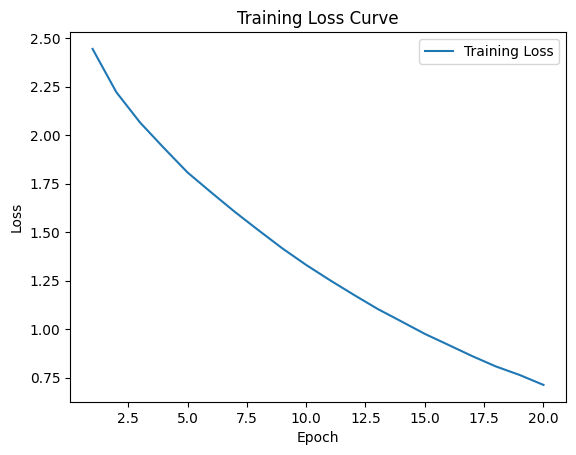

In [201]:
trained_model = train_model(train_tokenized, val_tokenized)

In [24]:
torch.cuda.empty_cache()

In [211]:
# Create a generation config
generation_config = {
    "early_stopping": True,
    "num_beams": 4,
    "no_repeat_ngram_size": 3,
    "forced_bos_token_id": 0
}

# Update the model's configuration with the generation configuration
trained_model.config.generation_config = generation_config

# Save the model
trained_model.save_pretrained("./bart_model_final")

In [23]:
# my trained model
saved_model_path = "./bart_model_final" 
model = BartForConditionalGeneration.from_pretrained(saved_model_path).to(device)


In [25]:
model_name = "facebook/bart-base"
tokenizer = BartTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [27]:
# Evaluate T5 model
from transformers import T5Tokenizer, T5ForConditionalGeneration
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [226]:
# Step 5: Evaluate Model
def evaluate_model(model, val_data, tokenizer, batch_size=16):
    scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    scores = []
    
    model.eval()  # Set the model to evaluation mode
    total_samples = len(val_data)

    with torch.no_grad():  # Disable gradient calculation
        for i in tqdm(range(0, total_samples, batch_size), desc="Evaluating Model"):
            batch = val_data[i:i + batch_size]
            inputs = tokenizer([example['text'] for example in batch], return_tensors="pt", max_length=1024,padding=True, truncation=True).to(device)
            summary_ids = model.generate(inputs['input_ids'], max_length=128, num_beams=4, early_stopping=True)
            generated_summaries = tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

            for j, example in enumerate(batch):
                rouge = scorer.score(example['summary'], generated_summaries[j])
                scores.append(rouge)

    avg_scores = {metric: sum([s[metric].fmeasure for s in scores]) / len(scores) for metric in scores[0]}
    print("Average ROUGE Scores:", avg_scores)
    return avg_scores

# Assuming you have your trained model and validation data ready
avg_rouge_scores = evaluate_model(trained_model, val_data, tokenizer)

Evaluating Model: 100%|███████████████████████████████████████████████████████████████████████████████| 125/125 [10:42<00:00,  5.14s/it]

Average ROUGE Scores: {'rouge1': 0.3299575843585844, 'rouge2': 0.12359658841023975, 'rougeL': 0.24225107185299596}


In [26]:
print("\nEvaluating T5 Model")
t5_avg_scores = evaluate_model(t5_model, val_data, t5_tokenizer)



Evaluating T5 Model


Evaluating Model: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:14<00:00,  3.57s/it]

Average ROUGE Scores: {'rouge1': 0.18600446527625358, 'rouge2': 0.021525739041356653, 'rougeL': 0.12749502398716525}


In [29]:
def generate_summary(model, tokenizer, text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True).to(device)
    attention_mask = inputs['attention_mask']  # Get the attention mask
    summary_ids = model.generate(inputs['input_ids'], attention_mask=attention_mask, max_length=1024, num_beams=5, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [31]:
import spacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

In [32]:
from spacy import displacy

def visualize_ner(text):
    # Process the text with SpaCy
    doc = nlp(text)
    
    # Visualize the entities
    displacy.render(doc, style="ent", jupyter=True)

In [33]:
example_text = input("Enter text to summarize: ")
visualize_ner(example_text)
print('\n')
generated_summary = generate_summary(model, tokenizer, example_text)
print("Generated Summary:", generated_summary)
print('\n')
# Generate summary using T5 small
t5_input = t5_tokenizer("summarize: " + example_text, return_tensors="pt", max_length=512, truncation=True).to(device)
t5_output = t5_model.generate(t5_input['input_ids'], max_length=512, num_beams=4, early_stopping=True)
t5_summary = t5_tokenizer.decode(t5_output[0], skip_special_tokens=True)
print("Generated Summary from T5 Small Model:", t5_summary)


Enter text to summarize:  Before modern electromagnetic motors, experimental motors that worked by electrostatic force were investigated. The first electric motors were simple electrostatic devices described in experiments by Scottish monk Andrew Gordon and American experimenter Benjamin Franklin in the 1740s.[2][3] The theoretical principle behind them, Coulomb's law, was discovered but not published, by Henry Cavendish in 1771. This law was discovered independently by Charles-Augustin de Coulomb in 1785, who published it so that it is now known by his name.[4] Due to the difficulty of generating the high voltages they required, electrostatic motors were never used for practical purposes.  The invention of the electrochemical battery by Alessandro Volta in 1799[5] made possible the production of persistent electric currents. Hans Christian Ørsted discovered in 1820 that an electric current creates a magnetic field, which can exert a force on a magnet. It only took a few weeks for Andr



Generated Summary: The first electrostatic motors were discovered by Benjamin Franklin and Charles-Augustin de Coulomb . Coulomb's law allowed the production of persistent electric currents . The first electrochemical devices were invented by Alessandro Volta in 1799 .


Generated Summary from T5 Small Model: the first electric motors were simple electrostatic devices described in experiments by monk Andrew Gordon and american experimenter Benjamin Franklin in the 1740s. the theory behind them, Coulomb's law, was discovered but not published, by Henry Cavendish in 1771. the invention of the electrochemical battery by Alessandro Volta in 1799 made possible the production of persistent electric currents.
